In [7]:
!pip install ipython-sql

In [282]:
import sqlite3
import pandas as pd
import backtrader as bt
from datetime import datetime


In [377]:
df1 = pd.read_csv('data.csv')
df1['tradedate'] = pd.to_datetime(df1['tradedate'], format= '%Y%m%d' )

In [378]:
df2 = df1.groupby('symbol')

In [399]:
rel = df2.get_group('REL.IN')
ilc = df2.get_group('ILC.IN')
hds = df2.get_group('HDS.IN')
wip = df2.get_group('WIP.IN')

In [512]:
cerebro = bt.Cerebro()
cerebro.broker.setcash(100000000.0)
cerebro.broker.getcash()

100000000.0

In [513]:
class TestStrategy(bt.Strategy):
    params = (
    ('fast', 50),
    ('slow', 200)
    )
    
    def __init__(self):
        self.crossovers = []
        self.orders_ = []
        self.bars_executed = [None, None, None, None]
        
        for d in self.datas:
            ma_fast = bt.ind.SMA(d, period = self.params.fast)
            ma_slow = bt.ind.SMA(d, period = self.params.slow)
            self.order = None
            self.orders_.append(self.order)
            self.crossover = bt.ind.CrossOver(ma_fast, ma_slow)
            self.crossovers.append(bt.ind.CrossOver(ma_fast, ma_slow))
            
    def notify_order(self, order):
        for i,d in enumerate(self.datas):
            orde = self.orders_[i]
            if order.status in [order.Submitted, order.Accepted]:          #Active Buy/Sell order submitted/accepted - Nothing to do
                continue
            if order.status in [order.Completed]:                          #Check if an order has been completed
                if order.isbuy():             
                    self.bar_executed = len(self) 
                    self.bars_executed[i] = self.bar_executed
                elif order.issell():             
                    self.bar_executed = len(self)
                    self.bars_executed[i] = self.bar_executed
            
    def next(self):
        
        money = cerebro.broker.getcash()
        for i,d in enumerate(self.datas):
#            cerebro.broker.setcash(money/4)           #strategy works much better if i comment out this line aka remove weights
            if (self.getposition(d).size == 0):       #if not in the market 
                if self.crossovers[i] > 0:
                    self.orders_[i] = self.buy(data = d)                  #long
                elif self.crossovers[i] < 0:                 
                    self.orders_[i] = self.sell(data = d)                 #short
            
            else:                                      #if in the market
                if len(self) >= (self.bars_executed[i] + 5):
                    self.orders_[i] = self.close(data = d)
                    
#                 if (self.getposition(d).size < 0):      #in the short position
#                     if (self.crossovers[i] >0):
#                         self.close(data = d)            #then close
                        
#                 else:                                   #in the long position
#                     if (self.crossovers[i] <0):
#                         self.close(data = d)            #then close
                
                        
    



In [514]:
class SMACloseSignal(bt.Indicator):
    lines = ('signal',)
    params = (('period', 200),) 
    
    def __init__(self):
        self.lines.signal = self.data - bt.indicators.SMA(period = self.p.period)
        
class SMAExitSignal(bt.Indicator):
    lines = ('signal',)
    params = (('p1', 50), ('p2', 200),)

    def __init__(self):
        sma1 = bt.indicators.SMA(period=self.p.p1)
        sma2 = bt.indicators.SMA(period=self.p.p2)
        self.lines.signal = sma1 - sma2
        

In [515]:
class PandasData(bt.feed.DataBase):
    params = (
        ('datetime', 'tradedate'),
        ('open', 'close'),
        ('high', 'close'),
        ('low', 'close'),
        ('close', 'close'),
        ('volume', None),
        ('openinterest', None)
        )

<IPython.core.display.Javascript object>


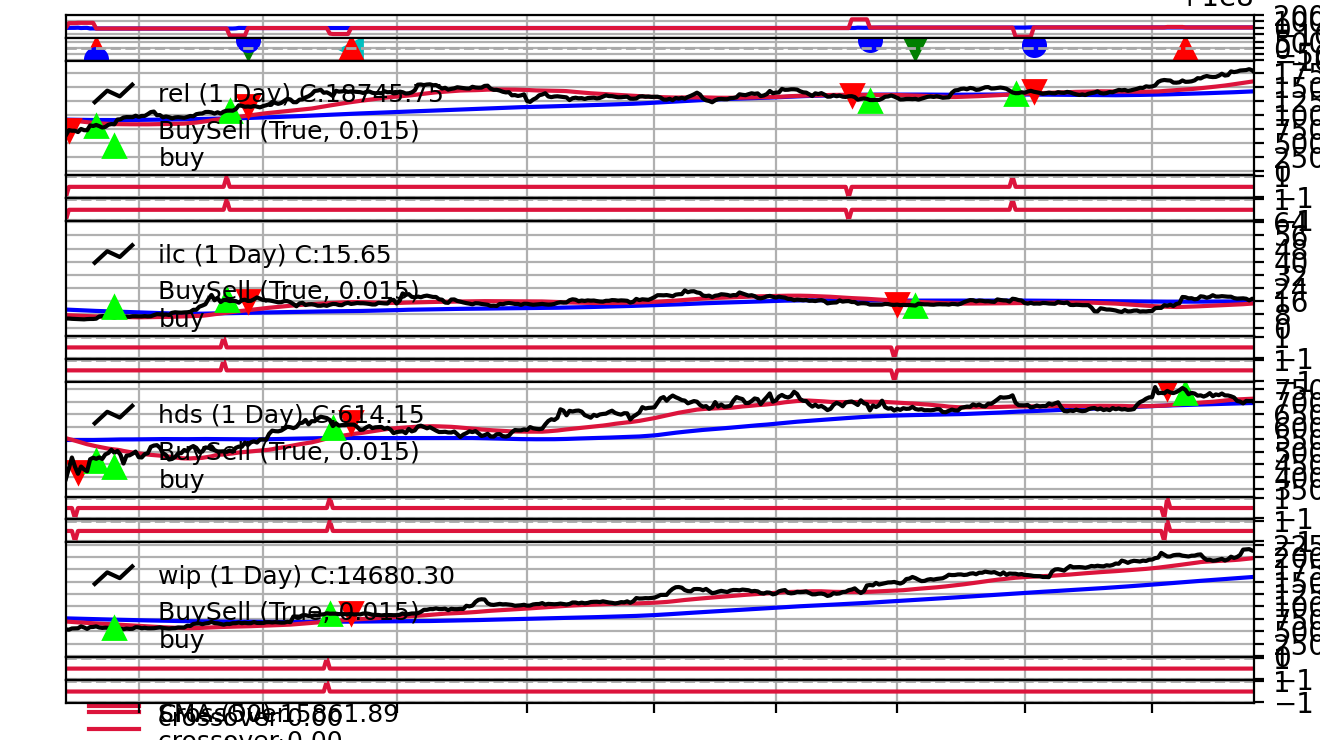

[[<Figure size 640x480 with 14 Axes>]]

In [516]:
#cerebro.add_signal(bt.SIGNAL_LONGSHORT, SMACloseSignal, period = 200)
#cerebro.add_signal(bt.SIGNAL_LONGEXIT, SMAExitSignal, p1 = 50, p2 = 200)
#cerebro.add_signal(bt.SIGNAL_SHORTEXIT, SMAExitSignal, p1 = 50, p2 = 200)

stocks = {'rel':rel, 'ilc':ilc, 'hds':hds, 'wip':wip}
cerebro.addstrategy(TestStrategy)
for s in stocks:
    data = bt.feeds.PandasData(dataname = stocks[s], datetime = 'tradedate', close = 'close', 
            open = 'close', high = 'close', low = 'close', volume = None, openinterest = None)
    cerebro.adddata(data, name = s)

#cerebro.addsizer(bt.sizers.PercentSizer, percents = 25)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name = 'sharpe')
cerebro.addanalyzer(bt.analyzers.Returns, _name = 'returns')
test = cerebro.run(runonce = False)
cerebro.plot(volume = False)



In [517]:
cerebro.broker.getvalue()

100000261.68000002

In [506]:
test[0].analyzers.sharpe.get_analysis()
test[0].analyzers.returns.get_analysis()

OrderedDict([('rtot', 2.61679657642841e-06),
             ('ravg', 4.3224257952236706e-10),
             ('rnorm', 1.0892513597197869e-07),
             ('rnorm100', 1.0892513597197869e-05)])